In [2]:
#!pip install bayesian-optimization

In [1]:
import sys
sys.path.append('..')
from src.models.pipeline import pipeline
import glob
import json
import os
import pandas as pd
import ast
from datetime import datetime

In [2]:
groundbase_dir = '../data/raw/groundbase'
transcripts_dir = os.path.join(groundbase_dir,'transcripts')
topic_dataset_path = os.path.join(groundbase_dir,'dataset.csv')
transcript_filespath = glob.glob(groundbase_dir + '/transcripts/*.json')

In [3]:
'''Read the transcript'''
transcripts_jsons = {}
for fl in transcript_filespath:
    with open(fl,encoding="utf8") as f:
        transcript =ast.literal_eval(f.read()) #json.load(f)
        vid = fl.split('\\')[-1].split('.')[0]
        #print(vid)
        transcripts_jsons[vid] = transcript

In [4]:
'''Read the videos metadata to perform on them the segmentation'''
df_videos = pd.read_csv(topic_dataset_path)

In [5]:


''' Transfer topic shifts time to seconds units instead HH:MM:SS'''

def topic_shifts_seconds(topic_shifts):
    tp_shift_sec=[]
    for tp in topic_shifts:
        intervals = tp.split(':')
        seconds = int(intervals[2])
        minutes = int(intervals[1]) * 60
        hours = int(intervals[0]) * 60 *60
        tp_shift_sec.append(seconds + minutes + hours)
    return tp_shift_sec


for video_id in transcripts_jsons.keys():    
    df_videos.at[df_videos['video id'] == video_id,'topic shifts(ends)'] =\
    topic_shifts_seconds(\
                         df_videos[df_videos['video id'] == \
                                   video_id]['topic shifts(ends)'])


In [6]:
df_videos

,shift index,topic shifts(ends),label,video,subject,youtube link,length,video id
0,0,677,"Syllabus , Textbook and references",Mod-01 Lec-01 Foundation of Scientific Computi...,Foundation of Scientific Computing,https://www.youtube.com/watch?v=MkiUBJcgdUY,01:05:06,MkiUBJcgdUY
1,1,765,course grading,Mod-01 Lec-01 Foundation of Scientific Computi...,Foundation of Scientific Computing,https://www.youtube.com/watch?v=MkiUBJcgdUY,01:05:06,MkiUBJcgdUY
2,2,1257,relationship between computing and science,Mod-01 Lec-01 Foundation of Scientific Computi...,Foundation of Scientific Computing,https://www.youtube.com/watch?v=MkiUBJcgdUY,01:05:06,MkiUBJcgdUY
3,3,1357,implemntation,Mod-01 Lec-01 Foundation of Scientific Computi...,Foundation of Scientific Computing,https://www.youtube.com/watch?v=MkiUBJcgdUY,01:05:06,MkiUBJcgdUY
4,4,1485,scientific computing uses,Mod-01 Lec-01 Foundation of Scientific Computi...,Foundation of Scientific Computing,https://www.youtube.com/watch?v=MkiUBJcgdUY,01:05:06,MkiUBJcgdUY
...,...,...,...,...,...,...,...,...
93,14,2947,NaN,Overview on Modern Cryptography,Cryptography and Network Security,https://www.youtube.com/watch?v=B-Xe7_mf2CY&fe...,00:58:22,B-Xe7_mf2CY
94,15,3072,NaN,Overview on Modern Cryptography,Cryptography and Network Security,https://www.youtube.com/watch?v=B-Xe7_mf2CY&fe...,00:58:22,B-Xe7_mf2CY
95,16,3276,NaN,Overview on Modern Cryptography,Cryptography and Network Security,https://www.youtube.com/watch?v=B-Xe7_mf2CY&fe...,00:58:22,B-Xe7_mf2CY
96,17,3423,NaN,Overview on Modern Cryptography,Cryptography and Network Security,https://www.youtube.com/watch?v=B-Xe7_mf2CY&fe...,00:58:22,B-Xe7_mf2CY


In [16]:
'''Global variables'''
df = pd.DataFrame()
vid = '2mC1uqwEmWQ'
video_metadata = df_videos.loc[df_videos['video id'] == vid]
ground_base = video_metadata['topic shifts(ends)'].values.tolist()[:-1]
n_clusters = len(ground_base) 
video_len = video_metadata['length'].values.tolist()[0]
curr_transcripts = transcripts_jsons[vid]    

In [13]:
def function_to_be_optimized(window_size,step_size,sim_thresh):
    print(vid)
    window_size = int(window_size)
    step_size = int(step_size)
    df_resulsts = pipeline.run(df,ground_base,vid,video_len,curr_transcripts,\
                 window_size=window_size,step_size=step_size,n_clusters=n_clusters,
                sim_thresh=sim_thresh,sim_filter=['median',(2,2)])
    print(df_resulsts['PRECISION'].values.tolist()[0])
    return df_resulsts['PRECISION'].values.tolist()[0]

In [9]:
from bayes_opt import BayesianOptimization


In [46]:
optimizer = BayesianOptimization(
    f=function_to_be_optimized,
    pbounds={'step_size':(10,60),'window_size':(20,200),'sim_thresh':(0,1)},
    verbose=2,
    random_state=1
)

|   iter    |  target   | sim_th... | step_size | window... |
-------------------------------------------------------------
                 0
count  3969.000000
mean      0.402950
std       0.264158
min       0.000000
25%       0.223191
50%       0.284691
75%       0.590177
max       1.000000


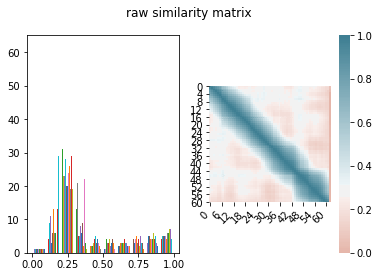

                 0
count  3969.000000
mean      0.379736
std       0.289866
min       0.000000
25%       0.223191
50%       0.284691
75%       0.590177
max       1.000000


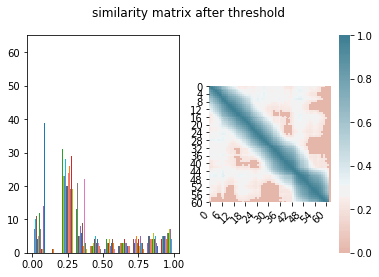

                 0
count  3969.000000
mean      0.397847
std       0.284728
min       0.000000
25%       0.236909
50%       0.292474
75%       0.603617
max       1.000000


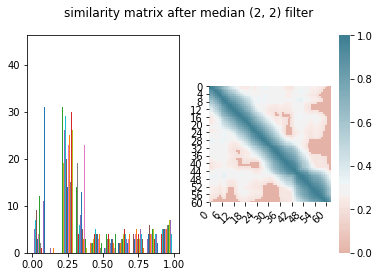

label 1 has done already cannot evaluate unsequentional segmentation, try other parameters
0.0
|  22       |  0.0      |  0.1987   |  10.08    |  140.4    |
                 0
count  5625.000000
mean      0.107353
std       0.158076
min       0.000000
25%       0.022384
50%       0.063753
75%       0.127814
max       1.000000


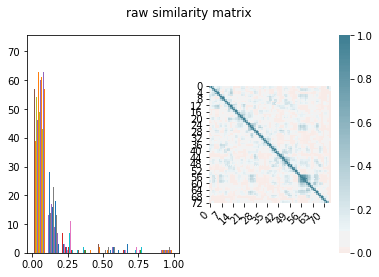

                 0
count  5625.000000
mean      0.011556
std       0.106883
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       1.000000


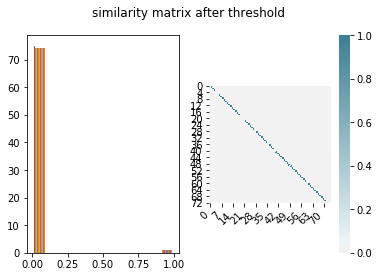

                 0
count  5625.000000
mean      0.010667
std       0.102736
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       1.000000


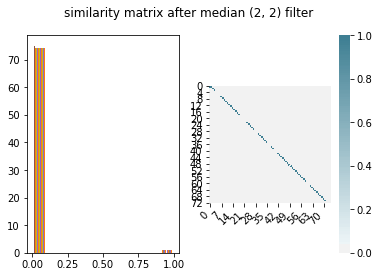

C:\Users\yaniv\Anaconda3\lib\site-packages\sklearn\manifold\spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


label 6 has done already cannot evaluate unsequentional segmentation, try other parameters
0.0
|  23       |  0.0      |  1.0      |  10.0     |  20.0     |
                 0
count  4356.000000
mean      0.339811
std       0.255295
min       0.000000
25%       0.174563
50%       0.243901
75%       0.424767
max       1.000000


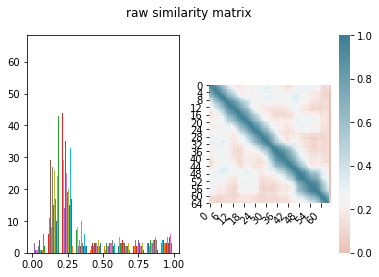

                 0
count  4356.000000
mean      0.011708
std       0.107581
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       1.000000


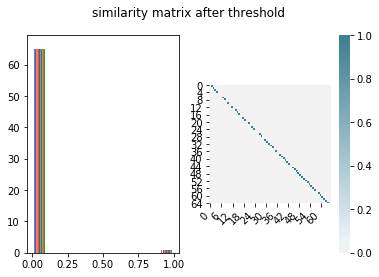

                 0
count  4356.000000
mean      0.009183
std       0.095397
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       1.000000


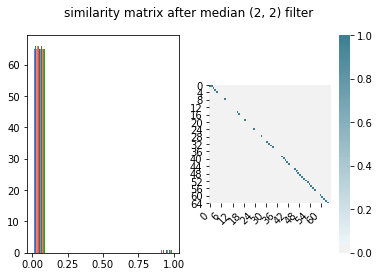

C:\Users\yaniv\Anaconda3\lib\site-packages\sklearn\manifold\spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


label 1 has done already cannot evaluate unsequentional segmentation, try other parameters
0.0
|  24       |  0.0      |  1.0      |  10.0     |  111.9    |
                0
count  169.000000
mean     0.250058
std      0.244091
min      0.028452
25%      0.114319
50%      0.174196
75%      0.271770
max      1.000000


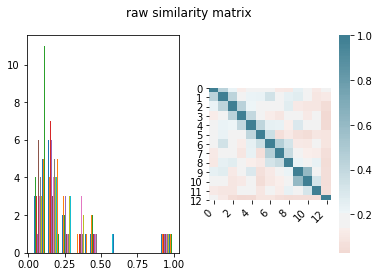

                0
count  169.000000
mean     0.250058
std      0.244091
min      0.028452
25%      0.114319
50%      0.174196
75%      0.271770
max      1.000000


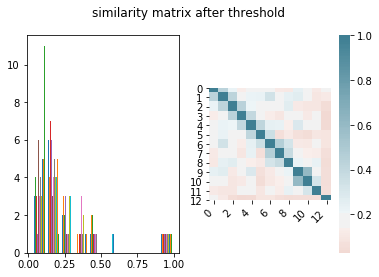

                0
count  169.000000
mean     0.292292
std      0.247398
min      0.093974
25%      0.161671
50%      0.197061
75%      0.320375
max      1.000000


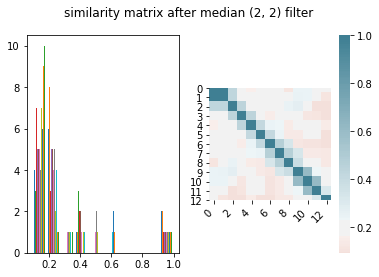

C:\Users\yaniv\Anaconda3\lib\site-packages\scipy\sparse\linalg\eigen\arpack\arpack.py:1572: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  RuntimeWarning)


TP: 6 , FP: 8, FN: 6
precision rate : 0.42857142857142855, recall rate : 0.5 
0.42857142857142855
|  25       |  0.4286   |  0.0      |  60.0     |  76.01    |
                0
count  256.000000
mean     0.429496
std      0.276774
min      0.042475
25%      0.263313
50%      0.314184
75%      0.621890
max      1.000000


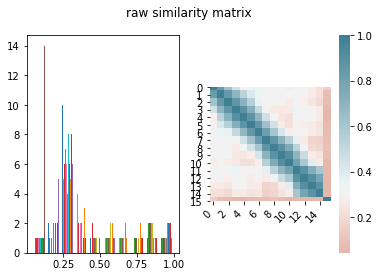

                0
count  256.000000
mean     0.050781
std      0.219981
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      1.000000


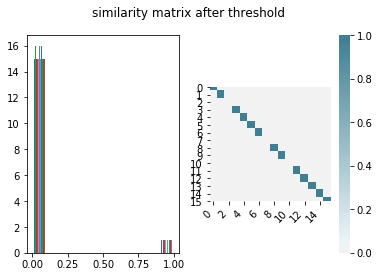

                0
count  256.000000
mean     0.046875
std      0.211785
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      1.000000


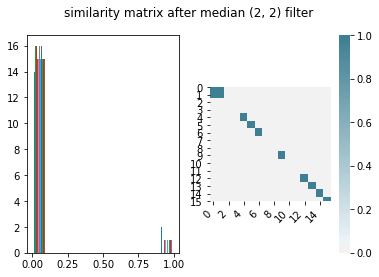

C:\Users\yaniv\Anaconda3\lib\site-packages\sklearn\manifold\spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


label 2 has done already cannot evaluate unsequentional segmentation, try other parameters
0.0
|  26       |  0.0      |  1.0      |  40.52    |  164.3    |
                 0
count  5184.000000
mean      0.193029
std       0.206339
min       0.000000
25%       0.078707
50%       0.127714
75%       0.204099
max       1.000000


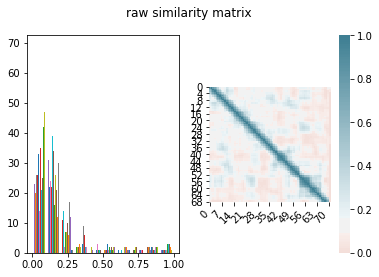

                 0
count  5184.000000
mean      0.012346
std       0.110434
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       1.000000


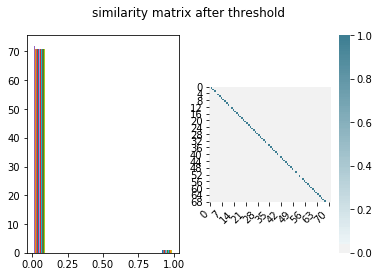

                 0
count  5184.000000
mean      0.010802
std       0.103382
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       1.000000


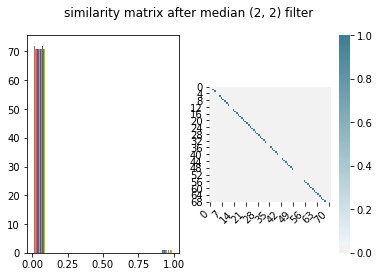

C:\Users\yaniv\Anaconda3\lib\site-packages\sklearn\manifold\spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


label 2 has done already cannot evaluate unsequentional segmentation, try other parameters
0.0
|  27       |  0.0      |  1.0      |  10.0     |  49.62    |
                0
count  441.000000
mean     0.155248
std      0.207046
min      0.000000
25%      0.050462
50%      0.099947
75%      0.169069
max      1.000000


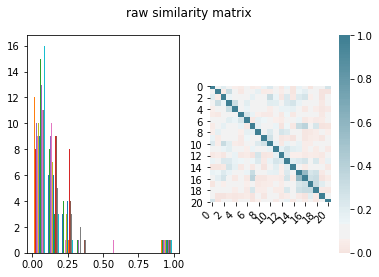

                0
count  441.000000
mean     0.047619
std      0.213201
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      1.000000


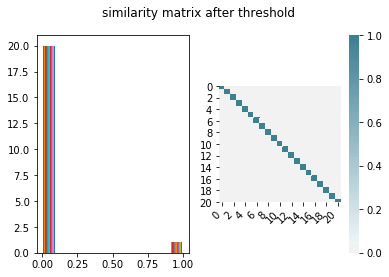

                0
count  441.000000
mean     0.052154
std      0.222590
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      1.000000


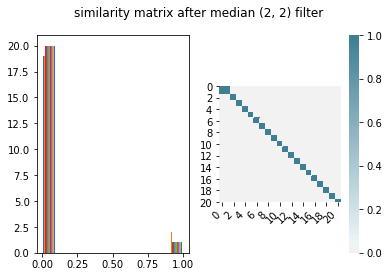

C:\Users\yaniv\Anaconda3\lib\site-packages\sklearn\manifold\spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


label 2 has done already cannot evaluate unsequentional segmentation, try other parameters
0.0
|  28       |  0.0      |  0.8445   |  36.02    |  34.13    |


In [54]:
optimizer.maximize(
    init_points = 0,
    n_iter=7
)

In [55]:
for i, res in enumerate(optimizer.res):
    print("Iteration {}: \n\t{}".format(i, res))
print("The max is %s " %(optimizer.max))

Iteration 0: 
	{'target': 0.0, 'params': {'sim_thresh': 0.417022004702574, 'step_size': 46.0162246721079, 'window_size': 20.02058746712208}}
Iteration 1: 
	{'target': 0.35714285714285715, 'params': {'sim_thresh': 0.30233257263183977, 'step_size': 17.337794540855654, 'window_size': 36.62094705838361}}
Iteration 2: 
	{'target': 0.5, 'params': {'sim_thresh': 0.0, 'step_size': 10.0, 'window_size': 200.0}}
Iteration 3: 
	{'target': 0.0, 'params': {'sim_thresh': 0.24412228188536877, 'step_size': 11.688985890591916, 'window_size': 198.61143622842334}}
Iteration 4: 
	{'target': 0.42857142857142855, 'params': {'sim_thresh': 0.1862602113776709, 'step_size': 27.278036352152387, 'window_size': 91.41814536152059}}
Iteration 5: 
	{'target': 0.0, 'params': {'sim_thresh': 0.538816734003357, 'step_size': 30.95972572016474, 'window_size': 143.33951007141673}}
Iteration 6: 
	{'target': 0.35714285714285715, 'params': {'sim_thresh': 0.20445224973151743, 'step_size': 53.90587181954727, 'window_size': 24.929

In [14]:
optimizer_MkiUBJcgdUY = BayesianOptimization(
    f=function_to_be_optimized,
    pbounds={'step_size':(10,100),'window_size':(20,400),'sim_thresh':(0,1)},
    verbose=2,
    random_state=1
)



In [71]:
optimizer_MkiUBJcgdUY.set_bounds(new_bounds={'step_size':(10,60),'window_size':(20,200),'sim_thresh':(0,1)})

|   iter    |  target   | sim_th... | step_size | window... |
-------------------------------------------------------------
2mC1uqwEmWQ
                0
count  784.000000
mean     0.325213
std      0.265573
min      0.013878
25%      0.151292
50%      0.213782
75%      0.431143
max      1.000000


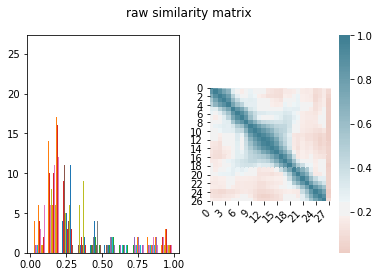

                0
count  784.000000
mean     0.273548
std      0.306722
min      0.000000
25%      0.000000
50%      0.213782
75%      0.431143
max      1.000000


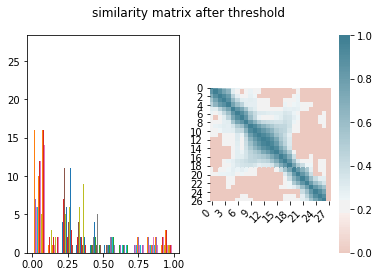

                0
count  784.000000
mean     0.310345
std      0.308563
min      0.000000
25%      0.000000
50%      0.240635
75%      0.472061
max      1.000000


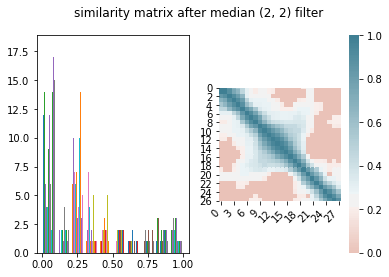

label 8 has done already cannot evaluate unsequentional segmentation, try other parameters
0.0
|  2        |  0.0      |  0.1863   |  41.1     |  170.8    |
2mC1uqwEmWQ
                0
count  484.000000
mean     0.450387
std      0.288344
min      0.041065
25%      0.219230
50%      0.340627
75%      0.711379
max      1.000000


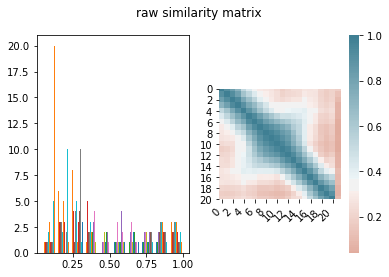

                0
count  484.000000
mean     0.276485
std      0.391628
min      0.000000
25%      0.000000
50%      0.000000
75%      0.711379
max      1.000000


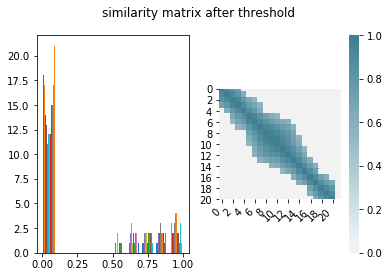

                0
count  484.000000
mean     0.307277
std      0.402150
min      0.000000
25%      0.000000
50%      0.000000
75%      0.747561
max      1.000000


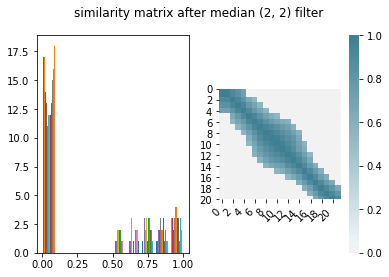

label 1 has done already cannot evaluate unsequentional segmentation, try other parameters
0.0
|  3        |  0.0      |  0.5388   |  47.73    |  280.4    |
2mC1uqwEmWQ
                0
count  225.000000
mean     0.149243
std      0.239136
min      0.000000
25%      0.030846
50%      0.073030
75%      0.150844
max      1.000000


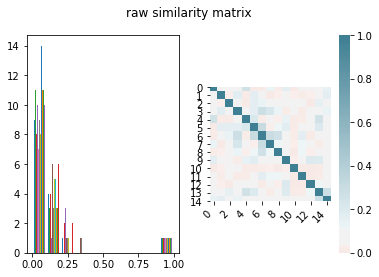

                0
count  225.000000
mean     0.087931
std      0.254850
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      1.000000


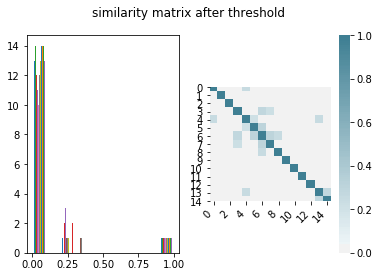

                0
count  225.000000
mean     0.101012
std      0.269114
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      1.000000


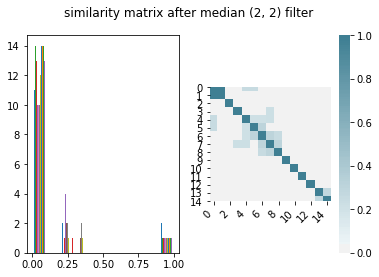

C:\Users\yaniv\Anaconda3\lib\site-packages\sklearn\manifold\spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
C:\Users\yaniv\Anaconda3\lib\site-packages\scipy\sparse\linalg\eigen\arpack\arpack.py:1572: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  RuntimeWarning)


TP: 2 , FP: 13, FN: 12
precision rate : 0.13333333333333333, recall rate : 0.14285714285714285 
0.13333333333333333
|  4        |  0.1333   |  0.2045   |  89.03    |  30.41    |


In [17]:
optimizer_MkiUBJcgdUY.maximize(
    init_points = 1,
    n_iter=0
)

In [73]:
for i, res in enumerate(optimizer_MkiUBJcgdUY.res):
    print("Iteration {}: \n\t{}".format(i, res))
print("The max is %s " %(optimizer_MkiUBJcgdUY.max))

Iteration 0: 
	{'target': 0.0, 'params': {'sim_thresh': 0.417022004702574, 'step_size': 74.82920440979423, 'window_size': 20.043462430591056}}
Iteration 1: 
	{'target': 0.0, 'params': {'sim_thresh': 0.30233257263183977, 'step_size': 23.208030173540173, 'window_size': 55.088666012143165}}
Iteration 2: 
	{'target': 0.16666666666666666, 'params': {'sim_thresh': 0.1862602113776709, 'step_size': 41.1004654338743, 'window_size': 170.77164020765457}}
Iteration 3: 
	{'target': 0.0, 'params': {'sim_thresh': 0.538816734003357, 'step_size': 47.72750629629653, 'window_size': 280.3834101507686}}
Iteration 4: 
	{'target': 0.0, 'params': {'sim_thresh': 1.0, 'step_size': 100.0, 'window_size': 177.59151121271952}}
Iteration 5: 
	{'target': 0.1111111111111111, 'params': {'sim_thresh': 0.033365394079127086, 'step_size': 42.84810392245922, 'window_size': 172.63373981820132}}
Iteration 6: 
	{'target': 0.0, 'params': {'sim_thresh': 1.0, 'step_size': 100.0, 'window_size': 400.0}}
Iteration 7: 
	{'target': 0.

In [10]:
optimizer_2mC1uqwEmWQ = BayesianOptimization(
    f=function_to_be_optimized,
    pbounds={'step_size':(10,60),'window_size':(20,200),'sim_thresh':(0,1)},
    verbose=2,
    random_state=1
)

|   iter    |  target   | sim_th... | step_size | window... |
-------------------------------------------------------------
2mC1uqwEmWQ
                0
count  784.000000
mean     0.105052
std      0.195431
min      0.000000
25%      0.011469
50%      0.044923
75%      0.104189
max      1.000000


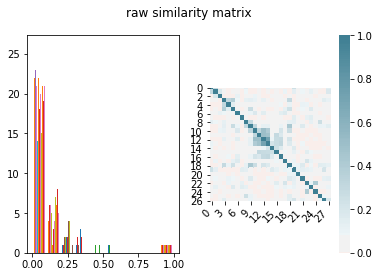

                0
count  784.000000
mean     0.042413
std      0.193964
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      1.000000


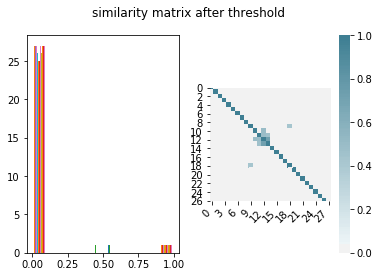

                0
count  784.000000
mean     0.045717
std      0.201898
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      1.000000


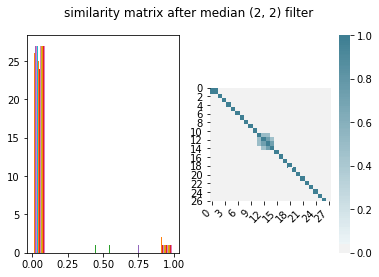

C:\Users\yaniv\Anaconda3\lib\site-packages\sklearn\manifold\spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


label 5 has done already cannot evaluate unsequentional segmentation, try other parameters
0.0
|  1        |  0.0      |  0.417    |  46.02    |  20.02    |
2mC1uqwEmWQ
                0
count  576.000000
mean     0.309945
std      0.261855
min      0.012653
25%      0.141732
50%      0.206499
75%      0.369177
max      1.000000


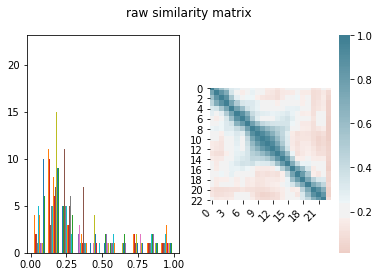

                0
count  576.000000
mean     0.176213
std      0.323492
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      1.000000


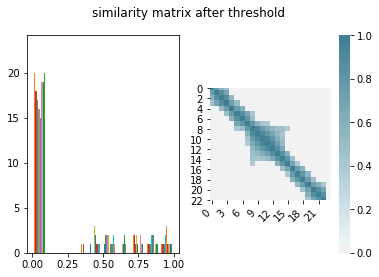

                0
count  576.000000
mean     0.202012
std      0.339716
min      0.000000
25%      0.000000
50%      0.000000
75%      0.439032
max      1.000000


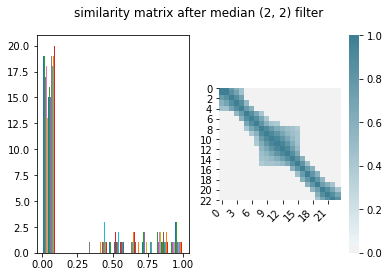

label 12 has done already cannot evaluate unsequentional segmentation, try other parameters
0.0
|  2        |  0.0      |  0.3758   |  49.49    |  159.4    |


In [11]:
optimizer_2mC1uqwEmWQ.maximize(
    init_points = 0,
    n_iter=1
)

In [13]:
for i, res in enumerate(optimizer_2mC1uqwEmWQ.res):
    print("Iteration {}: \n\t{}".format(i, res))
print("The max is %s " %(optimizer_2mC1uqwEmWQ.max))

Iteration 0: 
	{'target': 0.0, 'params': {'sim_thresh': 0.417022004702574, 'step_size': 46.0162246721079, 'window_size': 20.02058746712208}}
Iteration 1: 
	{'target': 0.0, 'params': {'sim_thresh': 0.30233257263183977, 'step_size': 17.337794540855654, 'window_size': 36.62094705838361}}
Iteration 2: 
	{'target': 0.3333333333333333, 'params': {'sim_thresh': 0.1862602113776709, 'step_size': 27.278036352152387, 'window_size': 91.41814536152059}}
Iteration 3: 
	{'target': 0.0, 'params': {'sim_thresh': 0.538816734003357, 'step_size': 30.95972572016474, 'window_size': 143.33951007141673}}
Iteration 4: 
	{'target': 0.0, 'params': {'sim_thresh': 0.20445224973151743, 'step_size': 53.90587181954727, 'window_size': 24.92976677562671}}
Iteration 5: 
	{'target': 0.0, 'params': {'sim_thresh': 0.5650250402008509, 'step_size': 58.95179729459112, 'window_size': 199.53092132071728}}
Iteration 6: 
	{'target': 0.13333333333333333, 'params': {'sim_thresh': 0.2948475339667701, 'step_size': 29.493717740756246,